In [46]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# native tools
import sys
from copy import copy
from collections import Counter
from joblib import dump, load

# for data analysis 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# statistical testing
from scipy.stats import ttest_ind

# for feature selection
from sklearn.feature_selection import VarianceThreshold

# feature engineering 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# for outlier detection
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# for imbalanced classes
from imblearn.over_sampling import SMOTENC

# linear models
from sklearn.linear_model import LogisticRegression

# non-linear models
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

# modeling building tools
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, precision_recall_curve, PrecisionRecallDisplay)


# custom functions, classes, etc ... 
sys.path.append("../Scripts")
from deep_learning import BuildNeuralNetArchitecture
from prep_data import PrepDataForModeling
from train_models import TrainModels
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch, sklearn_tuner
import kerastuner as kt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


----
# ML Pipeline 

The purpose of this notebook to show how one can use the `PrepDataForModeling` ETL pipeline and the `TrainModels` ML pipeline classes to build several models and visualize results with a few lines of code. 



---

## ETL Pipeline

In [79]:
data_path = "../Data/fraud_detection_bank_dataset.csv"
prep_data = PrepDataForModeling(data_path, y_col='targets', test_size=0.50)

X_train, y_train, X_test, y_test = prep_data.gen_model_ready_data(return_data=True)

INFO:root:Loading data from ../Data/fraud_detection_bank_dataset.csv
INFO:root:Number of features dropped 51. Number of features remaining 62
INFO:root:Using statistical_outlier_removal to remove outliers
INFO:root:statistical_outlier_removal reduced sample size from 20468 to 16088
INFO:root:Splitting data into training and test sets
INFO:root:Using SMOTENC to balance out labels in train set only.
INFO:root:Original imbalanced label count for training data Counter({0: 5788, 1: 2256})
INFO:root:New balanced label count for training data Counter({0: 5788, 1: 5788})


### Keras Tuner Gridsearch

In [38]:
# def build_model(hp):
    
#     model = keras.Sequential()
#     model.add(layers.Dense(units=hp.Int('units',
#                                         min_value=32,
#                                         max_value=512,
#                                         step=32),
                           
#                            activation='relu'))
    
#     model.add(layers.Dense(1, 
#                            activation='sigmoid'))
#     model.compile(
#         optimizer=keras.optimizers.Adam(
#             hp.Choice('learning_rate',
#                       values=[1.0,0.1, 0.01, 0.001])),
#         loss='binary_crossentropy',
#         metrics=['accuracy'])
    
#     return model
  
def build_model(hp):
    
    model_type = hp.Choice('model_type', ['random_forest', 'ridge'])

    if model_type == 'random_forest':

        model = ensemble.RandomForestClassifier(
                n_estimators=hp.Int('n_estimators', 10, 50, step=10),
                max_depth=hp.Int('max_depth', 3, 10)
            )
    else:
        
        model = linear_model.RidgeClassifier(
                alpha=hp.Float('alpha', 1e-3, 1, sampling='log')
        )
        
    return model

In [65]:
import kerastuner as kt
from sklearn import ensemble
from sklearn import datasets
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import KFold

In [57]:
def build_model(hp):

    model = ensemble.RandomForestClassifier(
            n_estimators=hp.Int('n_estimators', 10, 50, step=10),
            max_depth=hp.Int('max_depth', 3, 10))
  
    return model

In [97]:

max_trials = 10
num_initial_points = 3
seed = 1234

# oracle = kt.BayesianOptimization(
#     build_model,
#     objective="val_accuracy",
#     max_trials=max_trials,
#     num_initial_points=num_initial_points,
#     alpha=0.0001,
#     beta=2.6,
#     seed=seed,
#     # hyperparameters are included in hyper model
#     hyperparameters=None,
# )

orc = kt.Oracle(kt.Objective('score', direction='max'))
sklearn_tunner = kt.tuners.Sklearn(
                 orc,
                 build_model,
                 scoring="accuracy",
                 metrics="accuracy",
                 cv=KFold(n_splits=3, random_state=1234, shuffle=True))

In [98]:
sklearn_tunner.search(X_train, y_train)

NotImplementedError: 

In [120]:
import kerastuner as kt
from sklearn import ensemble
from sklearn import datasets
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection

def build_model(hp):
    model_type = hp.Choice('model_type', ['random_forest', 'ridge'])
    
    if model_type == 'random_forest':
        model = ensemble.RandomForestClassifier(
            n_estimators=hp.Int('n_estimators', min_value=10, 
                                                max_value=1100, 
                                                step=100),
            
            max_depth=hp.Int('max_depth', min_value=3,
                                          max_value=15,
                                          step=2)
        )
        
    else:
        model = linear_model.RidgeClassifier(
            alpha = hp.Choice('alpha',
                    values=[10.0,1.0,0.1,0.01,0.001]))
    return model

tuner = kt.tuners.Sklearn(
    oracle=kt.oracles.BayesianOptimization(
        objective=kt.Objective('score', 'max'),
        max_trials=10),
    hypermodel=build_model,
    scoring=metrics.make_scorer(metrics.accuracy_score),
    cv=model_selection.StratifiedKFold(n_splits=5),
    directory='./keras_tunner_runs',
    project_name='credit_fraud_3')


tuner.search(X_train, y_train)

best_model = tuner.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 00m 02s]
score: 0.9333333333333332

Best score So Far: 0.9416666666666667
Total elapsed time: 00h 00m 11s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [123]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
model_type (Choice)
{'default': 'random_forest', 'conditions': [], 'values': ['random_forest', 'ridge'], 'ordered': False}
n_estimators (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 1100, 'step': 100, 'sampling': None}
max_depth (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 15, 'step': 2, 'sampling': None}
alpha (Choice)
{'default': 10.0, 'conditions': [], 'values': [10.0, 1.0, 0.1, 0.01, 0.001], 'ordered': True}


In [124]:
best_model

RandomForestClassifier(max_depth=7, n_estimators=910)

---
## ML Pipeline

In [ ]:
# DITCH SKLEARN WARPPER AND USE KERAS TUNNER 

In [3]:
# model_list = ["LogisticRegression", 
#               "RandomForestClassifier",
#               "LGBMClassifier"
#               ]

model_list = ["LogisticRegression", 
                "dense_network"
              ]

train_models = TrainModels(X_train, 
                           y_train, 
                           X_test, 
                           y_test)

# Creates a data transform pipeline that handels categorical and numerical features differently
train_models.create_transform_portion_of_pipeline(prep_data.df)

#Performs a grid search for each pipeline object
train_models.grid_search_models(model_list)

best_pipeline = train_models.return_best_pipeline()

INFO:root:Building data transformer portion of the pipeline...
INFO:root:Training LogisticRegression ...


Fitting 3 folds for each of 2 candidates, totalling 6 fits


INFO:root:Logging LogisticRegression as best performing model.
INFO:root:Best LogisticRegression has test score 0.8834
INFO:root:Training dense_network ...


Fitting 3 folds for each of 1 candidates, totalling 3 fits


ValueError: Invalid parameter activation for estimator Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  array([ True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False, False,  True, False, False, False,  True]))])),
                ('model',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7fdd94a8b790>)]). Check the list of available parameters with `estimator.get_params().keys()`.

----
# Post Modeling Analysis

### Naive Accuracy

One way to know if our ML model's perdictions are any good is to compare their predictions with a naive baseline. 
The easiest and most intuitve baseline to create for classification models is a naive accuracy. 

Create a naive accuracy by calculating the percentage of samples that belong to the majority class in the test set (not fraud). This is the accuracy that we can expect if we were to just assume that all samples belong to the majority class. We would an accuracy far higher than 50% however we wouldn't actually be identifying any of the fraud cases this way. 

Let's see if our ML models produce an accuracy that is above this base line for comparison. 

In [80]:
train_models.create_metric_df()

,Accuracy,Precision,Recall,F1_Score
LogisticRegression,0.8921,0.7704,0.8604,0.8129
RandomForestClassifier,0.9304,0.8856,0.8549,0.8700
LGBMClassifier,0.9331,0.8769,0.8777,0.8773
Naive Baseline,0.7275,NaN,NaN,NaN


### Adjust the Classification Threshold

Binary classification models predict a value ranging from 0.0 to 1.0 which can be interpreted as a probability of class membership. 

If probability is above 0.5, then sample is assigned to the positive class (fraud). 

If probability is below 0.5, then sample is assigned to the negative class (no fraud). 

By changing the classification threshold to a value other than 0.5, we can change the model scores with respect to Precision and Recall. 

This is important because sometimes we prefer to minimize False Positive over False Negatives or vice versa. 

The `adj_threshold` parameter shows the results if we adjust the classification threshold to try to balance the Precision and Recall scores. 

Notice how there is now a `New_Threshold` column shows the new classification threshold that is responsible for the adjusted Precision and Recall scores. 

In [81]:
train_models.create_metric_df(adj_threshold=True)

,Accuracy,Precision,Recall,F1_Score,New_Threshold
LogisticRegression,0.8968,0.7873,0.8513,0.8181,0.5295
RandomForestClassifier,0.9306,0.8758,0.8686,0.8722,0.4800
LGBMClassifier,0.9334,0.8613,0.9005,0.8805,0.4268
Naive Baseline,0.7275,NaN,NaN,NaN,NaN


## Are Feature Importances Statistically Significant?

A very nice attribute of tree ensemble models is that they rank the importance of features by the amount of information gain they provide during the feature splitting that occurs during the training of the models. 

Although our dataset is anonymized, we can imagine being curious if these so called importance features have differing values between the classes that are statistically significant. If so, we can feel much more confident in the modeling results and create anti-fraud software using these results. 

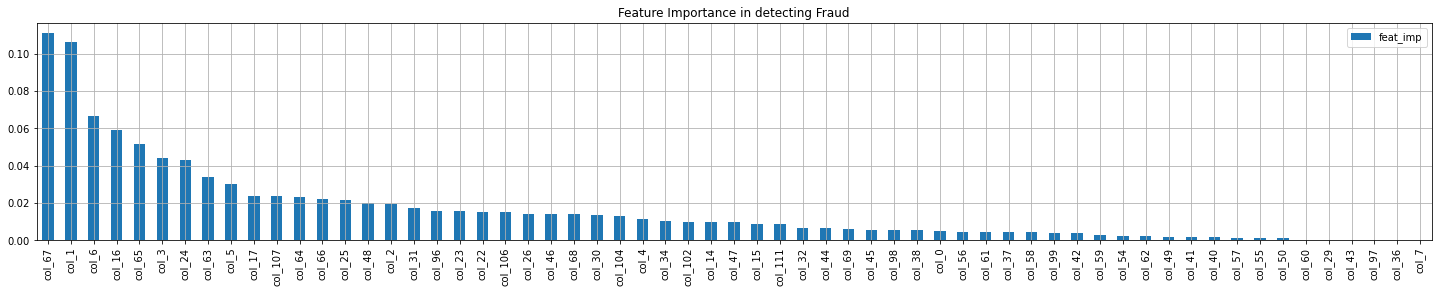

In [119]:
df_feat_importance = train_models.create_feature_importance_df(best_model, prep_data.x_cols)

title = "Feature Importance in detecting Fraud"
df_feat_importance.sort_values("feat_imp", ascending=False).plot(kind="bar", grid=True, legend=True,
                                                          figsize=(25, 4), use_index=True, title=title);

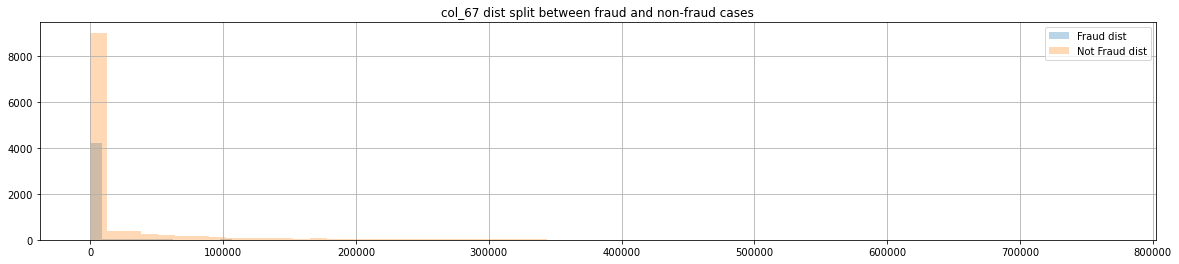

In [129]:
most_imp_feat = df_feat_importance.sort_values("feat_imp", ascending=False).index[0]

fraud_mask = prep_data.df_outliers_removed.targets == 1 
not_fraud_mask = prep_data.df_outliers_removed.targets == 0

fraud = prep_data.df_outliers_removed[fraud_mask][most_imp_feat]
no_fraud = prep_data.df_outliers_removed[not_fraud_mask][most_imp_feat]

title = "{} dist split between fraud and non-fraud cases".format(most_imp_feat)
plt.title(title)
fraud.hist(alpha=0.3, figsize=(20,4), bins=60, label="Fraud dist")
no_fraud.hist(alpha=0.3, figsize=(20,4), bins=60, label="Not Fraud dist");
plt.legend();

## Hypothesis Testing 

Let's split values from the most important feature into two distributions - fraud and not fraud - and see if the resulting distributions have a difference in mean that is statistically different. 

- Null: means are the same
- Alter: Means are not the same
- p-value < 0.5 -> We reject the Null
- p-value > 0.5 -> we fail to refect the Null


In [118]:
# these means are very different but let's run the test anyways
fraud.mean(), no_fraud.mean()

(5981.460315648677, 25989.26397565096)

In [117]:
_ , p_value = ttest_ind(fraud, no_fraud)
p_value

1.7782304388797554e-66

### Future Work

The distribution of values from `col_67` between fraud and non-fraud cases have a statistically significatn difference in their mean. This means that, whatever col_67 represents, fraud and non-fraud cases have, in this case, very different characteristics that we should be able to see in the data inself - abscent any predictive models. 

- One potential path forward is to circle back to EDA and investigate the details of these differences. 
- Another potential path forward is to start applying business logic to these differences and create action plans for bettering understand the characteristics of fraud and prevent it. 